In [1]:
#!/usr/bin/env python3
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


def visualize_from_file(matrix_path=None, interactions_path=None,
                        figsize=(10,6), save_path=None):

    def read_adjacency_matrix(filepath):
        with open(filepath, "r") as f:
            lines = f.readlines()
        matrix = [[float(x) for x in line.strip().split()] for line in lines]
        return np.array(matrix)

    def build_graph_from_matrix(matrix):
        G = nx.DiGraph()
        size = matrix.shape[0]
        G.add_nodes_from(range(size))
        for i in range(size):
            for j in range(size):
                if matrix[i, j] != 0:
                    G.add_edge(i, j)
        return G

    def read_gene_interactions(filepath):
        interactions = []
        with open(filepath, "r") as f:
            for line in f:
                parts = list(map(float, line.strip().split(",")))
                v = int(parts[0])
                nregs = int(parts[1])
                regs = list(map(int, parts[2:2 + nregs]))
                Ks = parts[2 + nregs:2 + 2 * nregs]
                coops = parts[2 + 2 * nregs:]
                interactions.append((v, nregs, regs, Ks, coops))
        return interactions

    def build_graph_from_interactions(interactions):
        G = nx.DiGraph()
        for target, _, regs, _, _ in interactions:
            for reg in regs:
                G.add_edge(reg, target)
        return G

    def draw_graph(G, interactions=None):
        pos = nx.spring_layout(G, seed=42, k=0.9, iterations=100)
        plt.figure(figsize=figsize)

        # --- node coloring ---
        if interactions is None:
            # cell mode: all nodes skyblue
            node_colors = 'skyblue'
        else:
            # gene mode: any node with no incoming edges is a master regulator
            masters = {n for n in G.nodes() if G.in_degree(n) == 0}
            node_colors = [
                'orange' if n in masters else 'pink'
                for n in G.nodes()
            ]

        nx.draw_networkx_nodes(
            G, pos,
            node_color=node_colors,
            node_size=700
        )
        nx.draw_networkx_labels(G, pos, font_size=10)

        # --- edge drawing ---
        if interactions is None:
            nx.draw_networkx_edges(
                G, pos,
                arrows=True,
                edge_color='gray',
                arrowstyle='-|>',
                arrowsize=20,
                width=1.5
            )
        else:
            edge_list, colors = [], []
            for target, _, regs, Ks, _ in interactions:
                for reg, k in zip(regs, Ks):
                    edge_list.append((reg, target))
                    colors.append('red' if k < 0 else 'green')
            nx.draw_networkx_edges(
                G, pos,
                edgelist=edge_list,
                edge_color=colors,
                arrowstyle='-|>',
                arrowsize=20,
                width=2
            )

        plt.axis('off')
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, bbox_inches='tight')
            print(f"Saved graph to {save_path}")
        plt.show()

    # Dispatcher
    if matrix_path:
        matrix = read_adjacency_matrix(matrix_path)
        G = build_graph_from_matrix(matrix)
        draw_graph(G)
    elif interactions_path:
        inters = read_gene_interactions(interactions_path)
        G = build_graph_from_interactions(inters)
        draw_graph(G, interactions=inters)
    else:
        raise ValueError("You must specify either a matrix_path or interactions_path.")


Saved graph to ../../experiments_final/num_6/gene_dag_output.png


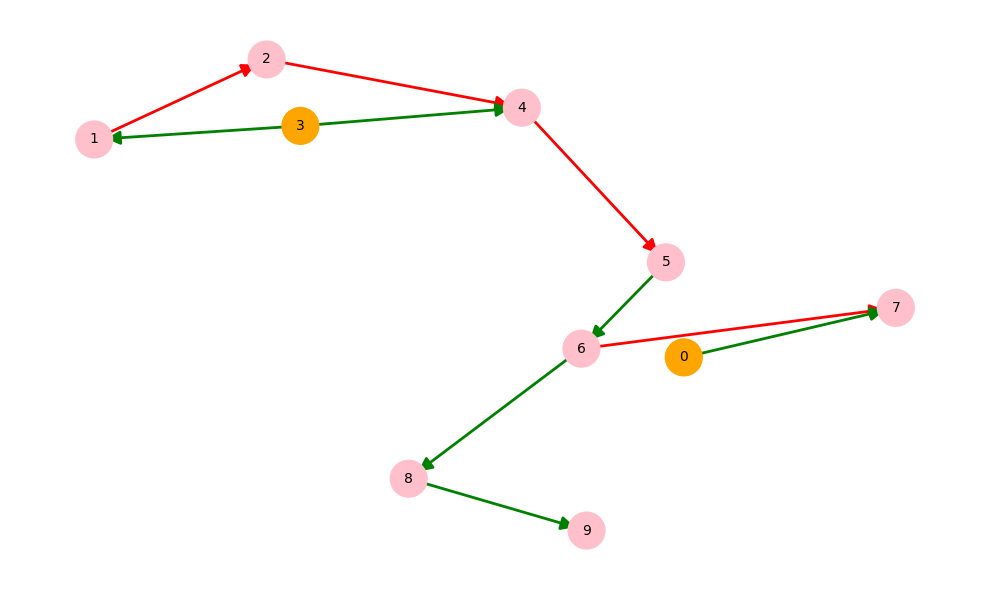

In [3]:
#visualize_from_file(matrix_path="../../experiments_final/num_2/perturbed_matrix.tab",save_path="cell_dag_output.png")
visualize_from_file(interactions_path="../../experiments_final/num_6/gene_interactions.txt", save_path="../../experiments_final/num_6/gene_dag_output.png")
